In [1]:
import numpy as np
import pandas as pd
import os
import csv
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.calibration import calibration_curve
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from scipy import stats
from pyampute.ampute import MultivariateAmputation
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from lifelines import CoxPHFitter, WeibullFitter, WeibullAFTFitter
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM
from datetime import datetime, date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from os.path import isfile, join
from sklearn.metrics import mean_absolute_error, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from time import time
from sksurv.ensemble import RandomSurvivalForest
from sksurv.svm import FastSurvivalSVM
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score)
from sksurv.metrics import brier_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sksurv.util import Surv
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter
from data import load_dataset 
from sklearn.metrics import make_scorer
from sksurv.metrics import concordance_index_censored
from sklearn.pipeline import Pipeline
import warnings 
warnings.filterwarnings('ignore')
from sklearn.isotonic import IsotonicRegression


drive = 'H'
main_path = drive + ':/Shared drives/CKD_Progression/data/CKD_COHORT_Jan2010_Mar2024_v3.csv'
data_path = drive + ':/Shared drives/CKD_Progression/data/'
docs_path = drive + ':/Shared drives/CKD_Progression/docs/'
save_path = drive + ':/Shared drives/CKD_Progression/save/'
resu_path = drive + ':/Shared drives/CKD_Progression/result/'
covariates_path = docs_path + 'covariates.csv'
removecols_path = docs_path + 'remove_columns.csv'

plt.rcParams['font.family'] = 'Arial'
covariates, order_covariates, long_df = load_dataset(get_columns = True)
long_df['time'] = long_df['time'].replace(0, 0.001)

def concordance_scorer(y_true, y_pred):
    events = y_true['event']
    times  = y_true['time']
    return concordance_index_censored(events, times, y_pred)[0]

def concordance_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return concordance_index_censored(y['status'], y['time'], y_pred)[0]

def brier_score_scorer(estimator, X, y):
    y_pred = estimator.predict_survival_function(X)
    return brier_score(y['status'], y['time'], y_pred, time_point = 1)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['variable'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

def calculate_nll_loss(model, X, y_true):
    survival_probs = model.predict_survival_function(X)  
    nll = 0  
    for i, fn in enumerate(survival_probs):
        time_at_event = y_true['time'][i]
        if time_at_event <= 0:
            continue 
        prob_of_survival = fn(time_at_event)
        event_status = y_true['status'][i]
        if event_status:
            nll -= np.log(1 - prob_of_survival)
        else:
            nll -= np.log(prob_of_survival)
    return nll / len(survival_probs) 

def calculate_median_survival_time(surv_func):
    for t, prob in zip(surv_func.x, surv_func.y):
        if prob <= 0.5:
            return t
    return surv_func.x[-1] 

def calculate_cindex(model, X, y_true):
    model.fit(X, y_true)
    surv_funcs = model.predict(X) 
    times = y_true['time']
    events = y_true['status']
    # predicted_survival_times = np.array([calculate_median_survival_time(fn) for fn in surv_funcs])
    # c_index = concordance_index_censored(events.astype(bool), times, predicted_survival_times)[0]
    c_index = model.score(X, y_true)
    return c_index

def calculate_cindex_lifelines(model, X, y_true):
    surv_funcs = model.predict(X)

    c_index = 0
    for i in range(len(surv_funcs)):
        kmf = KaplanMeierFitter()
        kmf.fit(surv_funcs[i].x, surv_funcs[i].y)
        predicted_survival_time = kmf.median_survival_time_

        c_index += concordance_index_censored(y_true['status'].iloc[i], y_true['time'].iloc[i], predicted_survival_time)[0]

    return c_index / len(surv_funcs)

def permutation_importance_rsf(model, X, y, metric_func, n_repeats = 2, random_state = None):
    rng = np.random.RandomState(random_state)
    baseline_score = metric_func(model, X, y)  
    scores = np.zeros((n_repeats, X.shape[1]))

    for i in tqdm(range(X.shape[1])):  
        X_permuted = X.copy()
        for n in range(n_repeats):  
            X_permuted[:, i] = rng.permutation(X[:, i])  
            permuted_score = metric_func(model, X_permuted, y)  
            scores[n, i] = permuted_score - baseline_score  
    importances_mean = np.mean(scores, axis = 0)
    importances_std  = np.std(scores,  axis = 0)
    return importances_mean, importances_std

def adaptive_calibration_error(y_true, y_pred, num_bins=10):
    sorted_indices = np.argsort(y_pred)
    sorted_y_pred = y_pred[sorted_indices]
    sorted_y_true = y_true[sorted_indices]

    bin_size = len(y_pred) // num_bins
    bins = [sorted_y_pred[i * bin_size:(i + 1) * bin_size] for i in range(num_bins)]
    true_bins = [sorted_y_true[i * bin_size:(i + 1) * bin_size] for i in range(num_bins)]
    
    calibration_error = 0.0
    for i in range(num_bins):
        mean_pred = np.mean(bins[i])
        mean_true = np.mean(true_bins[i])
        bin_error = np.abs(mean_pred - mean_true)
        calibration_error += bin_error * len(bins[i]) / len(y_pred)
    return calibration_error

def nonconformity_score(predicted_risk, true_status):
    return np.abs(predicted_risk - true_status)

def get_calibration_plot(y_test, y_calib, calibrated, prediction, pathway, folder_name):
    fraction_of_positives,  mean_predicted_value = calibration_curve(y_calib['status'], calibrated, n_bins = 20)
    fraction_of_prediction, mean_predicted_preds = calibration_curve( y_test['status'], prediction, n_bins = 20)
    inner, outer = pathway.split('_')[0], pathway.split('_')[2]
    plt.figure(figsize = (7, 6))
    plt.plot(mean_predicted_value, fraction_of_positives,  marker = 'o', markersize = 8, c = 'b', label = 'Calibrated')
    plt.plot(mean_predicted_preds, fraction_of_prediction, marker = 'o', markersize = 8, c = 'r', label = 'Uncalibrated')

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')

    plt.xlabel('Mean Predicted Probability', size = 15)
    plt.ylabel('Fraction of Positives', size = 15)
    plt.title(f'{inner} to {outer} Calibration Plot', size = 18)
    plt.legend()

    folder_path = resu_path + f'modeling/survivalsvm/calibration_plot/{folder_name}/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    plt.savefig(os.path.join(folder_path, f'calibration_{pathway}.png'))

def compute_brier_score_in_batches(model, X_test, y_test, y_train, time_grid, batch_size=100):
    brier_scores = []
    n_batches = int(np.ceil(len(X_test) / batch_size))

    for i in range(n_batches):
        X_batch = X_test[i * batch_size : (i + 1) * batch_size]
        y_batch = y_test[i * batch_size : (i + 1) * batch_size]

        surv_preds = model.predict_survival_function(X_batch)
        prediction_prob = np.array([fn(time_grid) for fn in surv_preds])
        brier_score = integrated_brier_score(
            y_train, y_batch, prediction_prob, time_grid)
        brier_scores.append(brier_score)
    return np.mean(brier_scores, axis = 0)

def extract_survival_probabilities(predictions, time_grid):
    prob_arrays = []
    for pred in predictions:
        probs = np.array([pred.get(t, 0) for t in time_grid]) 
        prob_arrays.append(probs)
    return np.array(prob_arrays)

concordance_scorer = make_scorer(concordance_scorer, greater_is_better = True)
brier_score_scorer = make_scorer(brier_score_scorer, greater_is_better = True)

c:\Users\student1\.conda\envs\sam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def filter_covariates(multivariate_covariates, pathway):
    ckd_related_vars = [
        'cho_normal', 'cho_high', 'tri_normal', 'tri_high',
        'glu_normal', 'glu_impaired', 'glu_high', 'hba_normal',
        'hba_prediabetes', 'hba_high', 'sglt2'
    ]
    
    general_vars = [
        'gender', 'age_less60', 'age_geq60',
        'cho_normal', 'cho_high', 'tri_normal', 'tri_high',
        'glu_normal', 'glu_impaired', 'glu_high', 'hba_normal',
        'hba_prediabetes', 'hba_high', 'sglt2'
    ]
    
    if pathway.lower().endswith('ckd'):
        filtered_covariates = [var for var in multivariate_covariates if var not in ckd_related_vars]
    else:
        filtered_covariates = [var for var in multivariate_covariates if var not in general_vars]
    
    return filtered_covariates

In [3]:
def main_survival_svm(folder_name, get_variance_inflation, get_interaction, get_importance, use_conformal, use_platt, save_variance):
    log_file = resu_path + f'modeling/survivalsvm/svm_results_log_{folder_name}.csv'
    if not os.path.exists(log_file):
        with open(log_file, mode = 'w', newline = '') as file:
            writer = csv.writer(file)
            writer.writerow(['pathway', 'best_params', 'fit_predict_time',  'covariates', 'num_covariates',
                            'survival_auc', 'survival_mauc', 'c_index', 'c_index_cal', 'brier', 'brier_cal', 'ace', 'coverage'])
            
    pathways = long_df['pathway'].unique().tolist()
    for path in ['CKD3A_to_DEAD', 'CKD3A_to_CKD4', 'CKD3A_to_CKD5A', 'CKD3A_to_CKD5B', 'CKD3B_to_CKD5A', 'CKD3B_to_CKD5B', 'CKD4_to_CKD5B']:
        pathways.remove(path)

    scaler = MinMaxScaler()
    multicollinear_threshold = 10
    for pathway in tqdm(pathways):
        print(f'Processing pathway: {pathway}')
        if   'CKD' in pathway.split('_')[0] and 'CKD' in pathway.split('_')[2]:
            sheet_pathway = 'CKD_to_CKD'
        elif 'CKD' in pathway.split('_')[0] and 'CVD' in pathway.split('_')[2]:
            sheet_pathway = 'CKD_to_CVD'
        else:
            sheet_pathway = 'CKD_to_CKD'

        transition_df = long_df[long_df['pathway'] == pathway]

        univariate  = pd.read_excel(resu_path + f'univariate/LR_test/{pathway}.xlsx')
        interaction = pd.read_excel(resu_path + f'univariate/univariate_interaction.xlsx', sheet_name = sheet_pathway)
        multivariate_covariates = univariate[univariate['pvalue'] < 0.20]['variable'].tolist()
        multivariate_primary    = univariate[univariate['pvalue'] < 0.20]['variable'].tolist()
        # multivariate_covariates = filter_covariates(multivariate_covariates, pathway)
        
        if get_variance_inflation:
            if get_interaction:
                multivariate_covariates_set = set(multivariate_covariates)
                univariate_predictors = list(set(interaction['predictor1'].unique().tolist() + interaction['predictor2'].unique().tolist()))
                for index, row in interaction.iterrows():
                    interaction_name = row['variable']
                    predictor1 = row['predictor1']
                    predictor2 = row['predictor2']
                    
                    transition_df[interaction_name] = transition_df[predictor1] * transition_df[predictor2]
                    multivariate_covariates_set.discard(predictor1)
                    multivariate_covariates_set.discard(predictor2)
                multivariate_covariates_set.update(interaction['variable'].tolist())
                multivariate_covariates = list(multivariate_covariates_set)
                multivariate_covariates = list(set(multivariate_primary + multivariate_covariates))

            remove_features = pd.read_csv(resu_path + f'/modeling/survivalsvm/feature_importance/{folder_name}/{pathway}.csv')
            remove_features = remove_features[remove_features['importance_mean'] <= 0]['feature'].unique().tolist()

            X = transition_df[multivariate_covariates]
            X_scaled = scaler.fit_transform(X)
            X_scaled_df = pd.DataFrame(X_scaled, columns = multivariate_covariates)
            vif_result = calculate_vif(X_scaled_df)
            if save_variance:
                folder_path = resu_path + f'modeling/survivalsvm/variance_inflation/{folder_name}/'
                if not os.path.exists(folder_path):
                    os.mkdir(folder_path)  
                vif_result.to_csv(os.path.join(folder_path, f'{pathway}.csv'), index = False)
            multicollinear = vif_result[vif_result['VIF'] >= multicollinear_threshold]['variable'].tolist()
            multivariate_covariates = vif_result[vif_result['VIF'] < multicollinear_threshold]['variable'].tolist()
            print(f'There are {len(multicollinear)} covariates with high multicollinearity.')

        independent_df = transition_df.drop(columns = ['status'])
        independent_df = transition_df[multivariate_covariates]
        groundtruth_df = transition_df[['status', 'time']]
        groundtruth_df['status'] = groundtruth_df['status'].astype(bool)
        groundtruth_df['time'] = pd.to_numeric(groundtruth_df['time'])

        censored_weight = len(groundtruth_df) / groundtruth_df['status'].value_counts()[0]
        event_weight    = len(groundtruth_df) / groundtruth_df['status'].value_counts()[1]

        groundtruth_df['sample_weight'] = groundtruth_df['status'].apply(lambda x: event_weight if x else censored_weight)

        X, y = independent_df, Surv.from_dataframe('status', 'time', groundtruth_df)
        X_train, X_test, y_train, y_test, sample_weight_train,   sample_weight_test  = train_test_split(X, y, groundtruth_df['sample_weight'].to_numpy(), test_size = 0.30, random_state = 42)
        X_train, X_calib, y_train, y_calib, sample_weight_train, sample_weight_calib = train_test_split(
            X_train, y_train, sample_weight_train, test_size = 0.20, random_state = 42)

        X_train = scaler.fit_transform(X_train) 

        param_grid = {
            'alpha': [0.1, 1],
            'kernel': ['linear'],
            'gamma': [0.1, 0.5, 1]
        }

        start = time()
        cv = StratifiedKFold(n_splits = 5, shuffle = True,  random_state = 42)
        random_forest = FastKernelSurvivalSVM()

        survival_forest = RandomizedSearchCV(random_forest,
                                            param_grid,
                                            cv = cv,
                                            n_iter = 2,
                                            scoring = 'neg_log_loss')

        survival_forest.fit(X_train, y_train)
        best_survival = survival_forest.best_estimator_
        fit_predict_time = np.round(time() - start, 3)

        period_max = 100
        times = np.arange(y_test['time'].min(), period_max, 12)
        
        risk_score = best_survival.predict(X_calib) 
        surv_preds = best_survival.predict(X_calib)
        prediction = best_survival.predict(X_calib)

        if use_platt:
            risk_score = risk_score.reshape(-1, 1)
            risk_score_scaled = scaler.fit_transform(risk_score)
            platt_scaler = LogisticRegression()
            platt_scaler.fit(risk_score_scaled, y_test['status'])
            calibrated = platt_scaler.predict_proba(risk_score_scaled)[:, 1]

        else:
            iso_reg = IsotonicRegression(out_of_bounds = 'clip')
            iso_reg.fit(risk_score, y_calib['status'])

            risk_score_test = best_survival.predict(X_test)
            calibrated = iso_reg.transform(risk_score_test)
            
        if use_conformal:
            X_calib = scaler.transform(X_calib)

            calib_risk_scores = best_survival.predict(X_calib)
            nonconformity_scores = nonconformity_score(calib_risk_scores, y_calib['status'])
            quantile_value = np.quantile(nonconformity_scores, 1 - 0.05)

            lower_bound = risk_score - quantile_value
            upper_bound = risk_score + quantile_value

            covered  = np.logical_and(y_calib['status'] >= lower_bound, y_calib['status'] <= upper_bound)
            coverage = np.mean(covered)
            print(f'Coverage: {coverage * 100:.2f}%')
        else:
            coverage = np.NaN

        time_grid = np.linspace(1, period_max, 1000)
        surv_preds_test = best_survival.predict(X_test)

        prediction_prob = best_survival.predict(X_test)
        calibrated_prob = np.tile(calibrated[:, np.newaxis], (1, len(time_grid)))

        y_train_df = pd.DataFrame(y_train, columns = ['status', 'time'])
        y_tests_df = pd.DataFrame(y_test,  columns = ['status', 'time'])
        y_train_surv = Surv.from_dataframe('status', 'time', y_train_df)
        y_tests_surv = Surv.from_dataframe('status', 'time', y_tests_df)

        survival_auc,   survival_mauc = cumulative_dynamic_auc(y_train, y_test,  risk_score_test, times)
        survival_auc  = survival_auc[~np.isnan(survival_auc)]
        survival_mauc = np.mean(survival_mauc)
         
        c_index     = concordance_index_censored( y_test['status'],  y_test['time'], risk_score_test)[0] 
        c_index_cal = concordance_index_censored(y_calib['status'], y_calib['time'], risk_score)[0] 

        _, brier_score_val = brier_score(y_train, y_test, calibrated, period_max)
        _, brier_score_cal = brier_score(y_train, y_test, calibrated, period_max)

        brier_score_val, brier_score_cal = brier_score_val[0], brier_score_cal[0]
        ace_value = adaptive_calibration_error(y_test['status'], calibrated)

        with open(log_file, mode = 'a', newline = '') as file:
            writer = csv.writer(file)
            writer.writerow([pathway,
                            best_survival.get_params(),
                            fit_predict_time,
                            multivariate_covariates,
                            len(multivariate_covariates),
                            survival_auc,
                            survival_mauc,
                            c_index,
                            c_index_cal,
                            brier_score_val,
                            brier_score_cal,
                            ace_value,
                            coverage])
        print(f'\tFit and predict time of SVM at transition {pathway}: {fit_predict_time} seconds with {len(multivariate_covariates)} covariates.')
        print(f'\tC-index: {np.round(c_index, 2)} \tC-index (cal): {np.round(c_index_cal, 2)} \tBS: {np.round(brier_score_val/2, 2)} \tCBS: {np.round(brier_score_cal/10, 2)} \tACE: {np.round(ace_value, 5)}')

        prediction = [1 - p for p in prediction] 
        prediction = np.clip(prediction, 0, 1)
        get_calibration_plot(y_calib, y_test, calibrated, prediction, pathway, folder_name)

        if get_importance:
            importances_mean, importances_std = permutation_importance_rsf(best_survival,
                                                                           X_test.values, y_test,
                                                                           calculate_cindex,  
                                                                           n_repeats = 10, 
                                                                           random_state = 42)
            feature_importance_df = pd.DataFrame({'feature': X_test.columns, 'importance_mean': importances_mean, 'importance_std' : importances_std})
            feature_importance_df = feature_importance_df.sort_values(by =   'importance_mean', ascending = False)
            
            folder_path = resu_path + f'modeling/survivalsvm/feature_importance/{folder_name}/'
            if not os.path.exists(folder_path):
                os.mkdir(folder_path)  
            feature_importance_df.to_csv(os.path.join(folder_path, f'{pathway}.csv'), index = False)

  0%|          | 0/18 [00:00<?, ?it/s]

Processing pathway: CKD3A_to_CKD3B
Coverage: 95.03%
	Fit and predict time of SVM at transition CKD3A_to_CKD3B: 100.577 seconds with 20 covariates.
	C-index: 0.65 	C-index (cal): 0.66 	BS: 0.17 	CBS: 0.03 	ACE: 0.02305


  6%|▌         | 1/18 [19:12<5:26:27, 1152.19s/it]

Processing pathway: CKD3A_to_CVD
Coverage: 94.97%
	Fit and predict time of SVM at transition CKD3A_to_CVD: 101.156 seconds with 23 covariates.
	C-index: 0.62 	C-index (cal): 0.6 	BS: 0.17 	CBS: 0.03 	ACE: 0.01373


 11%|█         | 2/18 [38:58<5:12:37, 1172.32s/it]

Processing pathway: CVD_to_CKD3B
Coverage: 94.99%
	Fit and predict time of SVM at transition CVD_to_CKD3B: 4.744 seconds with 12 covariates.
	C-index: 0.65 	C-index (cal): 0.63 	BS: 0.21 	CBS: 0.04 	ACE: 0.03405


 17%|█▋        | 3/18 [39:39<2:43:56, 655.79s/it] 

Processing pathway: CVD_to_CKD4
Coverage: 95.08%
	Fit and predict time of SVM at transition CVD_to_CKD4: 19.826 seconds with 13 covariates.
	C-index: 0.69 	C-index (cal): 0.63 	BS: 0.45 	CBS: 0.09 	ACE: 0.01385


 22%|██▏       | 4/18 [41:51<1:44:44, 448.91s/it]

Processing pathway: CVD_to_CKD5A
Coverage: 96.58%
	Fit and predict time of SVM at transition CVD_to_CKD5A: 23.737 seconds with 14 covariates.
	C-index: 0.57 	C-index (cal): 0.66 	BS: 0.54 	CBS: 0.11 	ACE: 0.00354


 28%|██▊       | 5/18 [45:27<1:19:04, 364.95s/it]

Processing pathway: CVD_to_CKD5B
Coverage: 95.17%
	Fit and predict time of SVM at transition CVD_to_CKD5B: 28.083 seconds with 10 covariates.
	C-index: 0.55 	C-index (cal): 0.75 	BS: 0.53 	CBS: 0.11 	ACE: 0.00255


 33%|███▎      | 6/18 [48:02<58:43, 293.65s/it]  

Processing pathway: CVD_to_DEAD
Coverage: 95.28%
	Fit and predict time of SVM at transition CVD_to_DEAD: 33.636 seconds with 13 covariates.
	C-index: 0.71 	C-index (cal): 0.71 	BS: 0.47 	CBS: 0.09 	ACE: 0.00698


 39%|███▉      | 7/18 [53:00<54:03, 294.90s/it]

Processing pathway: CKD3B_to_CKD4
Coverage: 94.99%
	Fit and predict time of SVM at transition CKD3B_to_CKD4: 37.384 seconds with 24 covariates.
	C-index: 0.63 	C-index (cal): 0.65 	BS: 0.16 	CBS: 0.03 	ACE: 0.03231


 44%|████▍     | 8/18 [1:01:18<59:56, 359.67s/it]

Processing pathway: CKD3B_to_CVD
Coverage: 95.02%
	Fit and predict time of SVM at transition CKD3B_to_CVD: 37.226 seconds with 23 covariates.
	C-index: 0.6 	C-index (cal): 0.62 	BS: 0.14 	CBS: 0.03 	ACE: 0.02834


 50%|█████     | 9/18 [1:10:17<1:02:20, 415.60s/it]

Processing pathway: CKD3B_to_DEAD
Coverage: 95.13%
	Fit and predict time of SVM at transition CKD3B_to_DEAD: 31.785 seconds with 11 covariates.
	C-index: 0.66 	C-index (cal): 0.67 	BS: 0.49 	CBS: 0.1 	ACE: 0.00382


 56%|█████▌    | 10/18 [1:14:19<48:17, 362.19s/it] 

Processing pathway: CKD4_to_CKD5A
Coverage: 95.06%
	Fit and predict time of SVM at transition CKD4_to_CKD5A: 8.834 seconds with 17 covariates.
	C-index: 0.64 	C-index (cal): 0.65 	BS: 0.18 	CBS: 0.04 	ACE: 0.0535


 61%|██████    | 11/18 [1:15:40<32:11, 275.96s/it]

Processing pathway: CKD4_to_CVD
Coverage: 94.91%
	Fit and predict time of SVM at transition CKD4_to_CVD: 7.021 seconds with 12 covariates.
	C-index: 0.6 	C-index (cal): 0.66 	BS: 0.17 	CBS: 0.03 	ACE: 0.03643


 67%|██████▋   | 12/18 [1:16:35<20:52, 208.75s/it]

Processing pathway: CKD4_to_DEAD
Coverage: 95.06%
	Fit and predict time of SVM at transition CKD4_to_DEAD: 9.937 seconds with 14 covariates.
	C-index: 0.61 	C-index (cal): 0.54 	BS: 0.44 	CBS: 0.09 	ACE: 0.00683


 72%|███████▏  | 13/18 [1:18:06<14:26, 173.24s/it]

Processing pathway: CKD5A_to_CKD5B
Coverage: 94.92%
	Fit and predict time of SVM at transition CKD5A_to_CKD5B: 5.436 seconds with 20 covariates.
	C-index: 0.61 	C-index (cal): 0.62 	BS: 0.29 	CBS: 0.06 	ACE: 0.03501


 78%|███████▊  | 14/18 [1:19:05<09:14, 138.58s/it]

Processing pathway: CKD5A_to_CVD
Coverage: 94.87%
	Fit and predict time of SVM at transition CKD5A_to_CVD: 3.197 seconds with 14 covariates.
	C-index: 0.69 	C-index (cal): 0.6 	BS: 0.23 	CBS: 0.05 	ACE: 0.0218


 83%|████████▎ | 15/18 [1:19:40<05:22, 107.54s/it]

Processing pathway: CKD5A_to_DEAD
Coverage: 94.92%
	Fit and predict time of SVM at transition CKD5A_to_DEAD: 2.503 seconds with 9 covariates.
	C-index: 0.69 	C-index (cal): 0.62 	BS: 0.47 	CBS: 0.09 	ACE: 0.01634


 89%|████████▉ | 16/18 [1:19:57<02:40, 80.08s/it] 

Processing pathway: CKD5B_to_CVD
Coverage: 94.80%
	Fit and predict time of SVM at transition CKD5B_to_CVD: 3.597 seconds with 18 covariates.
	C-index: 0.68 	C-index (cal): 0.68 	BS: 0.2 	CBS: 0.04 	ACE: 0.06826


 94%|█████████▍| 17/18 [1:20:55<01:13, 73.56s/it]

Processing pathway: CKD5B_to_DEAD
Coverage: 95.22%
	Fit and predict time of SVM at transition CKD5B_to_DEAD: 3.874 seconds with 12 covariates.
	C-index: 0.66 	C-index (cal): 0.68 	BS: 0.47 	CBS: 0.09 	ACE: 0.01342


100%|██████████| 18/18 [1:21:20<00:00, 271.14s/it]


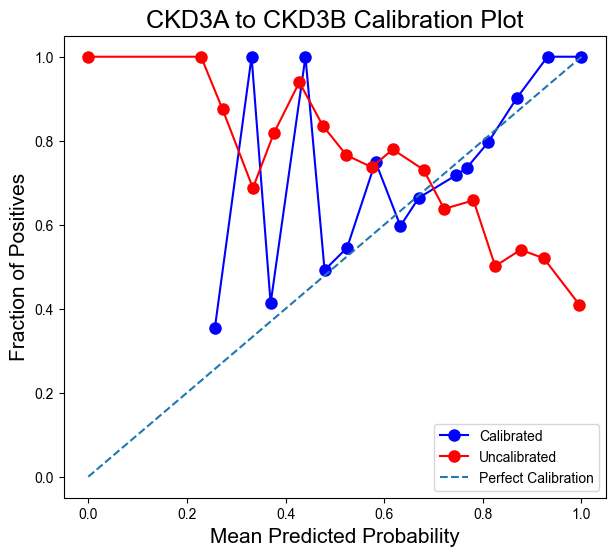

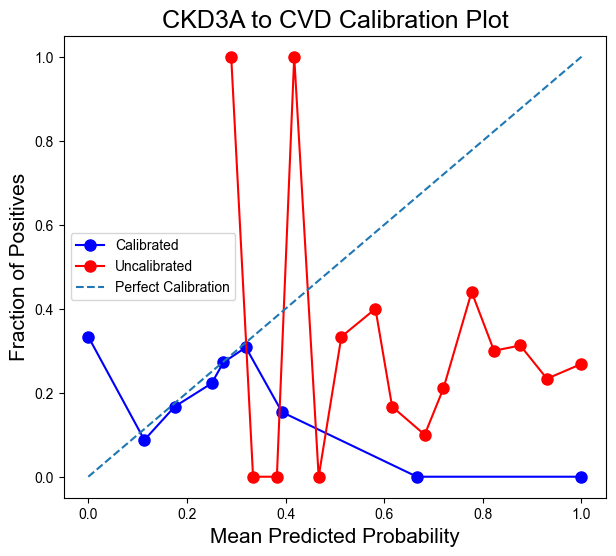

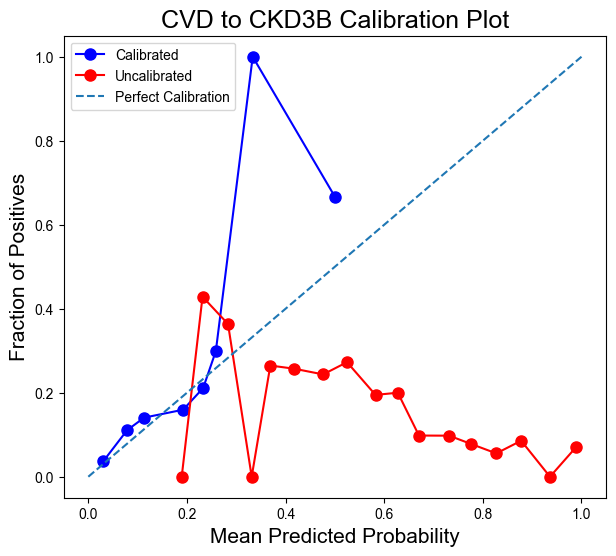

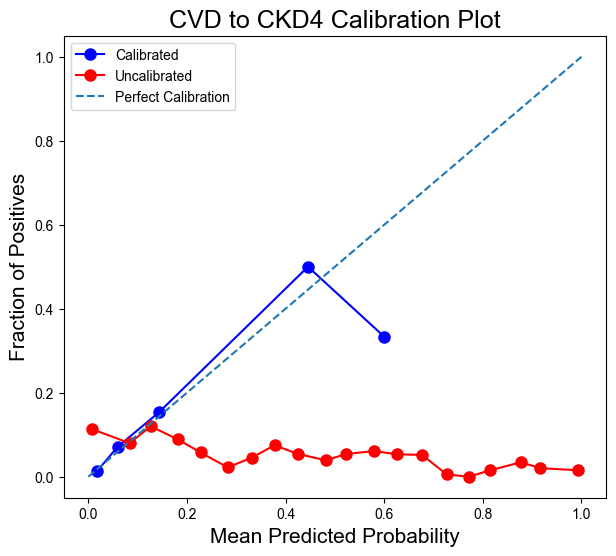

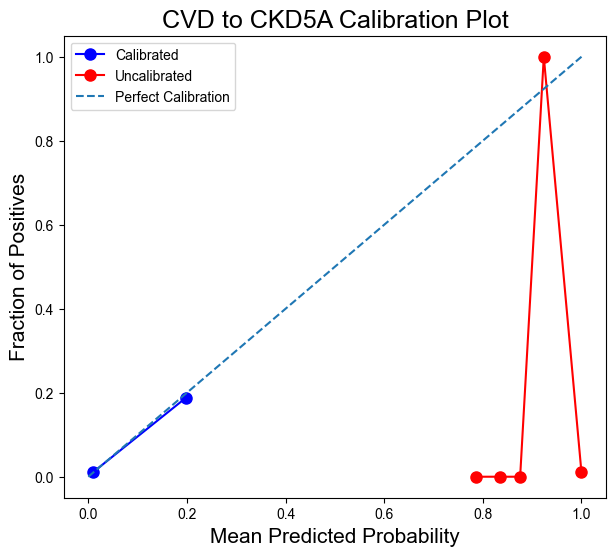

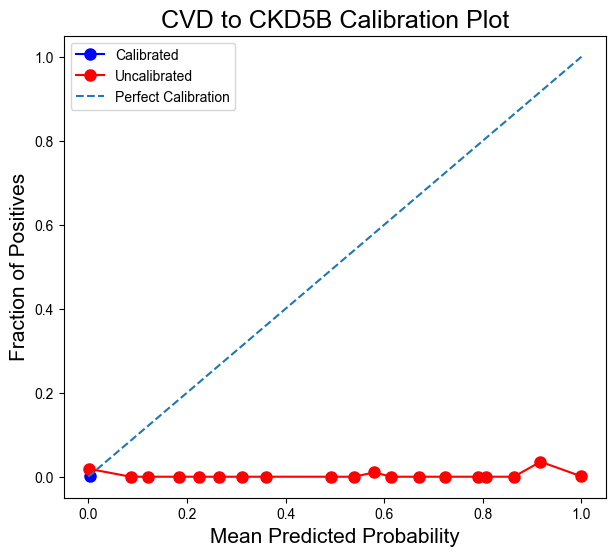

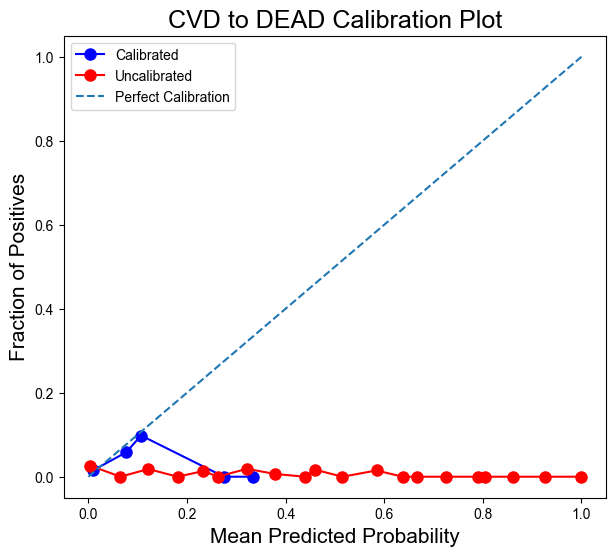

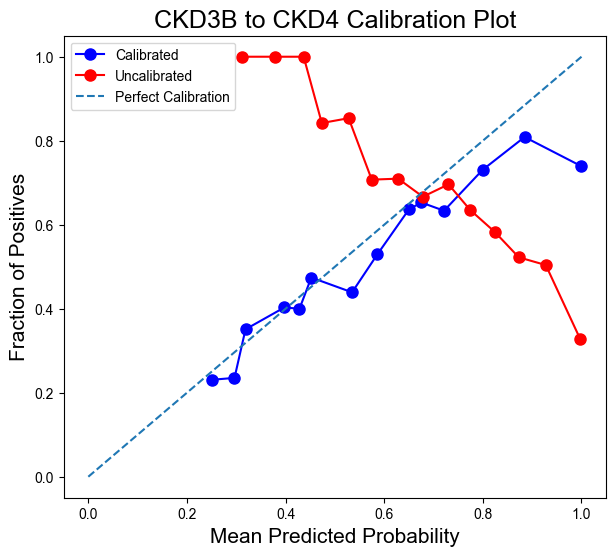

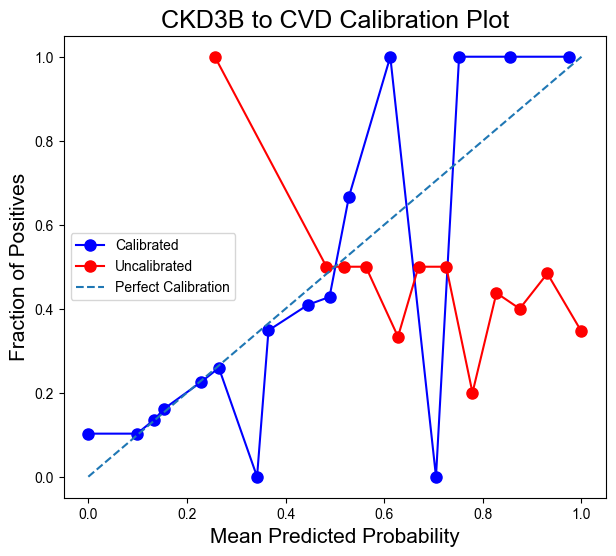

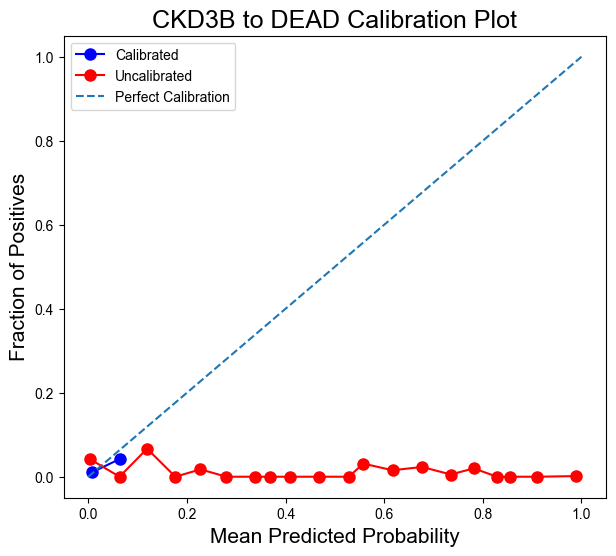

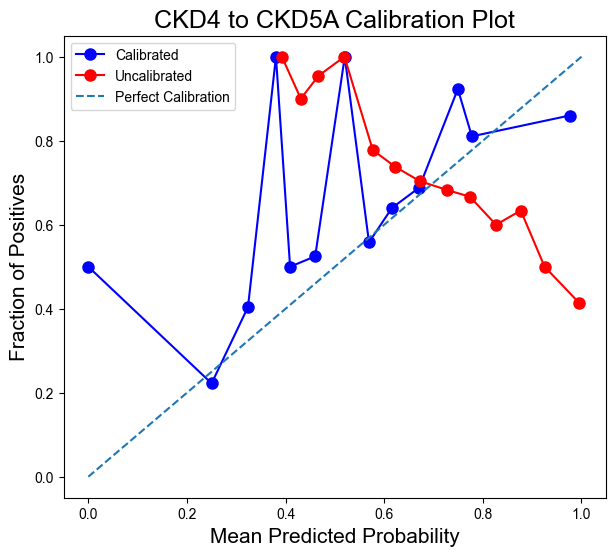

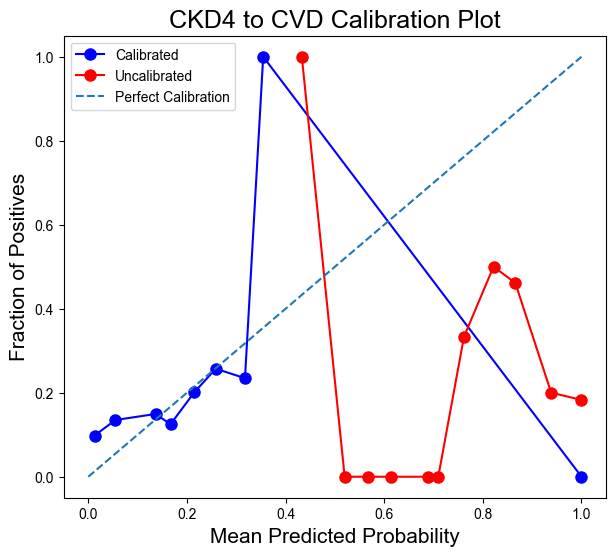

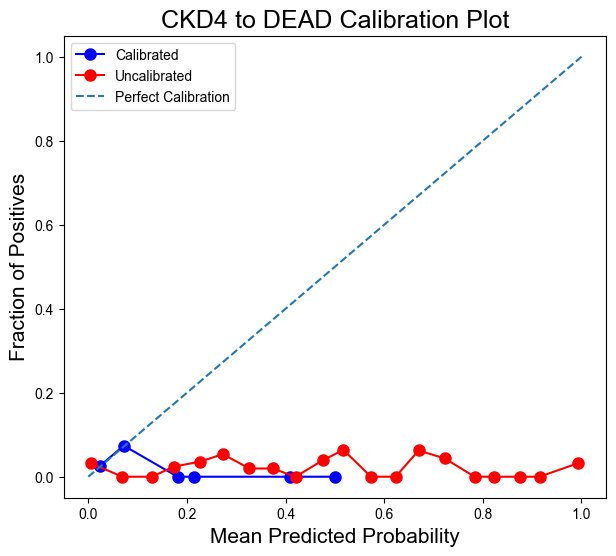

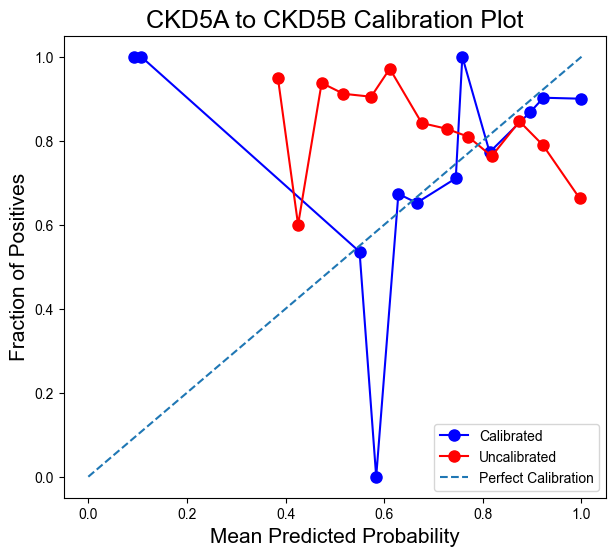

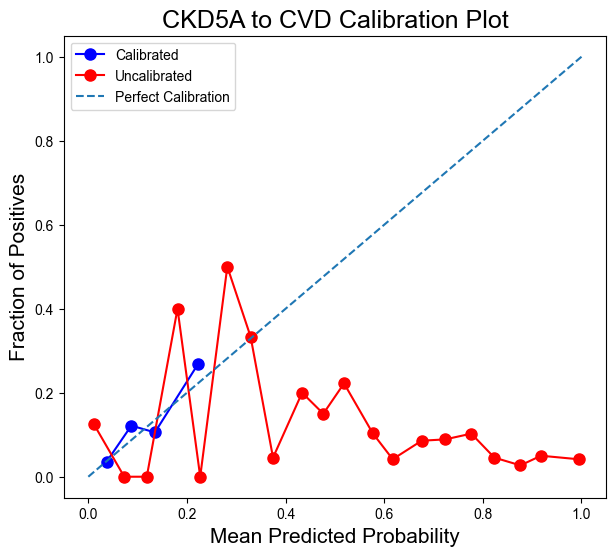

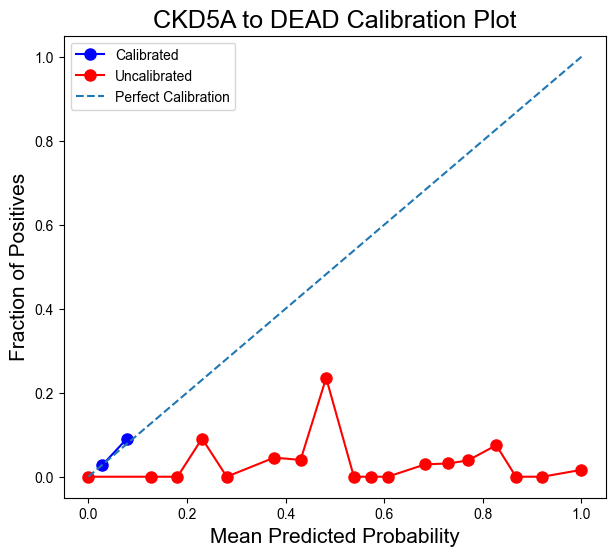

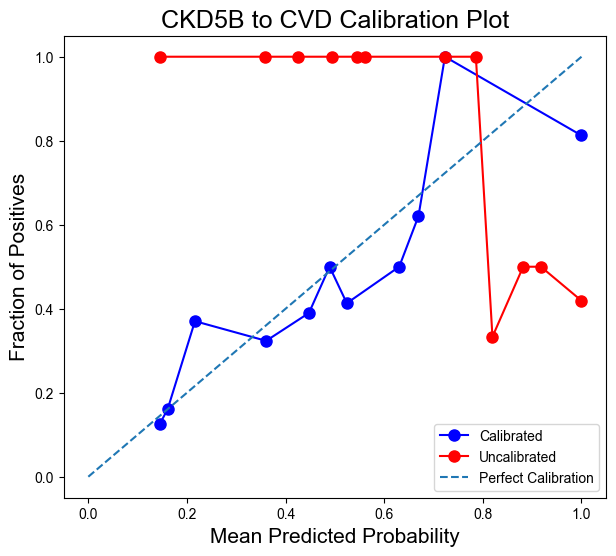

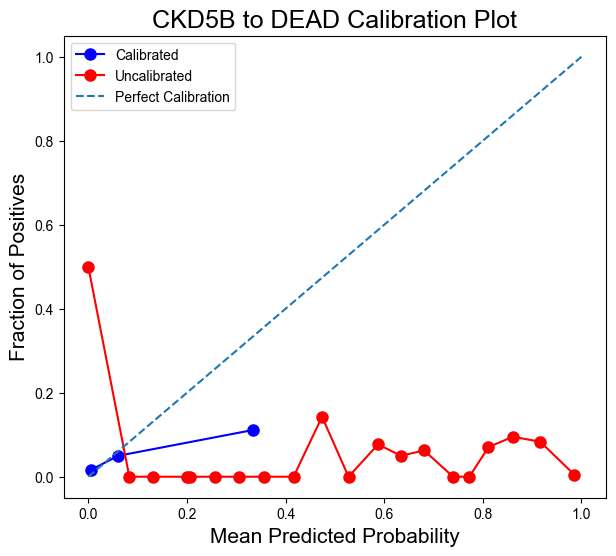

In [4]:
get_variance_inflation, get_interaction = False, False
get_importance = True
use_conformal  = True
use_platt = False
save_variance = True

folder_name, model_name = '23December2024_v3', 'survivalsvm'

main_survival_svm(folder_name, get_variance_inflation, get_interaction, get_importance, use_conformal, use_platt, save_variance)

  0%|          | 0/17 [00:00<?, ?it/s]

Processing pathway: CKD3A_to_CKD3B
There are 3 covariates with high multicollinearity.
Coverage: 94.81%


  6%|▌         | 1/17 [17:44<4:43:58, 1064.91s/it]

	Fit and predict time of RSF at transition CKD3A_to_CKD3B: 204.169 seconds with 29 covariates.
	C-index: 0.65 	BS: 0.23 	CBS: 0.32 	ACE: 0.00848
Processing pathway: CKD3A_to_CVD
There are 5 covariates with high multicollinearity.
Coverage: 95.23%


 12%|█▏        | 2/17 [43:37<5:37:59, 1351.95s/it]

	Fit and predict time of RSF at transition CKD3A_to_CVD: 109.485 seconds with 21 covariates.
	C-index: 0.64 	BS: 0.14 	CBS: 0.45 	ACE: 0.00708
Processing pathway: CVD_to_CKD3B
There are 1 covariates with high multicollinearity.
Coverage: 0.00%


 18%|█▊        | 3/17 [45:04<3:00:37, 774.09s/it] 

	Fit and predict time of RSF at transition CVD_to_CKD3B: 14.932 seconds with 19 covariates.
	C-index: 0.53 	BS: 0.2 	CBS: 0.44 	ACE: 0.01764
Processing pathway: CVD_to_CKD4
There are 2 covariates with high multicollinearity.
Coverage: 0.00%


 24%|██▎       | 4/17 [46:39<1:49:40, 506.18s/it]

	Fit and predict time of RSF at transition CVD_to_CKD4: 22.936 seconds with 13 covariates.
	C-index: 0.58 	BS: 0.11 	CBS: 0.76 	ACE: 0.0072
Processing pathway: CVD_to_CKD5A
There are 4 covariates with high multicollinearity.
Coverage: 95.54%


 29%|██▉       | 5/17 [47:49<1:09:45, 348.80s/it]

	Fit and predict time of RSF at transition CVD_to_CKD5A: 21.208 seconds with 13 covariates.
	C-index: 0.63 	BS: 0.03 	CBS: 0.98 	ACE: 0.0035
Processing pathway: CVD_to_CKD5B
There are 1 covariates with high multicollinearity.
Coverage: 0.00%


 35%|███▌      | 6/17 [49:34<48:44, 265.86s/it]  

	Fit and predict time of RSF at transition CVD_to_CKD5B: 33.308 seconds with 10 covariates.
	C-index: 0.58 	BS: 0.0 	CBS: 0.94 	ACE: 0.00097
Processing pathway: CVD_to_DEAD
There are 5 covariates with high multicollinearity.
Coverage: 95.59%


 41%|████      | 7/17 [51:28<36:03, 216.37s/it]

	Fit and predict time of RSF at transition CVD_to_DEAD: 20.333 seconds with 13 covariates.
	C-index: 0.68 	BS: 0.04 	CBS: 0.88 	ACE: 0.00385
Processing pathway: CKD3B_to_CKD4
There are 3 covariates with high multicollinearity.
Coverage: 95.46%


 47%|████▋     | 8/17 [55:23<33:20, 222.26s/it]

	Fit and predict time of RSF at transition CKD3B_to_CKD4: 33.4 seconds with 25 covariates.
	C-index: 0.65 	BS: 0.23 	CBS: 0.34 	ACE: 0.0039
Processing pathway: CKD3B_to_CVD
There are 5 covariates with high multicollinearity.
Coverage: 94.18%


 53%|█████▎    | 9/17 [59:39<31:01, 232.63s/it]

	Fit and predict time of RSF at transition CKD3B_to_CVD: 69.425 seconds with 23 covariates.
	C-index: 0.59 	BS: 0.18 	CBS: 0.34 	ACE: 0.01389
Processing pathway: CKD3B_to_DEAD
There are 3 covariates with high multicollinearity.
Coverage: 0.00%


 59%|█████▉    | 10/17 [1:05:43<31:54, 273.46s/it]

	Fit and predict time of RSF at transition CKD3B_to_DEAD: 49.851 seconds with 17 covariates.
	C-index: 0.49 	BS: 0.01 	CBS: 0.98 	ACE: 0.0042
Processing pathway: CKD4_to_CKD5A
There are 4 covariates with high multicollinearity.
Coverage: 94.72%


 65%|██████▍   | 11/17 [1:06:36<20:35, 205.86s/it]

	Fit and predict time of RSF at transition CKD4_to_CKD5A: 9.904 seconds with 22 covariates.
	C-index: 0.65 	BS: 0.23 	CBS: 0.36 	ACE: 0.01385
Processing pathway: CKD4_to_DEAD
There are 0 covariates with high multicollinearity.
Coverage: 0.00%


 71%|███████   | 12/17 [1:07:23<13:07, 157.42s/it]

	Fit and predict time of RSF at transition CKD4_to_DEAD: 16.546 seconds with 17 covariates.
	C-index: 0.55 	BS: 0.03 	CBS: 0.9 	ACE: 0.00741
Processing pathway: CKD5A_to_CKD5B
There are 4 covariates with high multicollinearity.
Coverage: 51.55%


 76%|███████▋  | 13/17 [1:07:44<07:44, 116.04s/it]

	Fit and predict time of RSF at transition CKD5A_to_CKD5B: 8.082 seconds with 24 covariates.
	C-index: 0.58 	BS: 0.15 	CBS: 0.51 	ACE: 0.0201
Processing pathway: CKD5A_to_CVD
There are 2 covariates with high multicollinearity.
Coverage: 0.00%


 82%|████████▏ | 14/17 [1:08:02<04:19, 86.49s/it] 

	Fit and predict time of RSF at transition CKD5A_to_CVD: 5.661 seconds with 20 covariates.
	C-index: 0.61 	BS: 0.15 	CBS: 0.64 	ACE: 0.0147
Processing pathway: CKD5A_to_DEAD
There are 0 covariates with high multicollinearity.
Coverage: 0.00%


 88%|████████▊ | 15/17 [1:08:19<02:11, 65.50s/it]

	Fit and predict time of RSF at transition CKD5A_to_DEAD: 3.943 seconds with 12 covariates.
	C-index: 0.7 	BS: 0.02 	CBS: 0.91 	ACE: 0.00501
Processing pathway: CKD5B_to_CVD
There are 3 covariates with high multicollinearity.
Coverage: 0.00%


 94%|█████████▍| 16/17 [1:08:33<00:50, 50.12s/it]

	Fit and predict time of RSF at transition CKD5B_to_CVD: 3.564 seconds with 22 covariates.
	C-index: 0.52 	BS: 0.12 	CBS: 0.35 	ACE: 0.02705
Processing pathway: CKD5B_to_DEAD
There are 0 covariates with high multicollinearity.
Coverage: 0.00%


100%|██████████| 17/17 [1:08:47<00:00, 242.80s/it]

	Fit and predict time of RSF at transition CKD5B_to_DEAD: 3.032 seconds with 13 covariates.
	C-index: 0.64 	BS: 0.01 	CBS: 0.97 	ACE: 0.00707


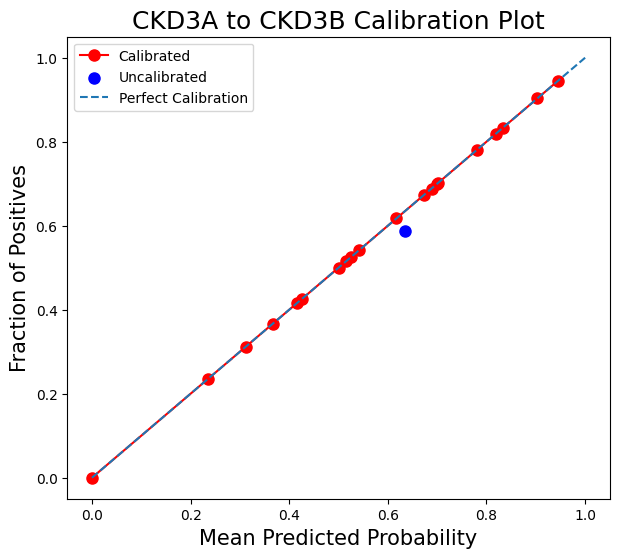

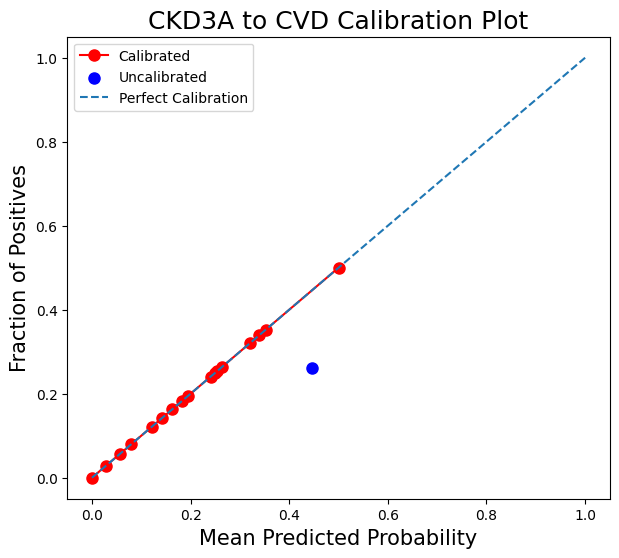

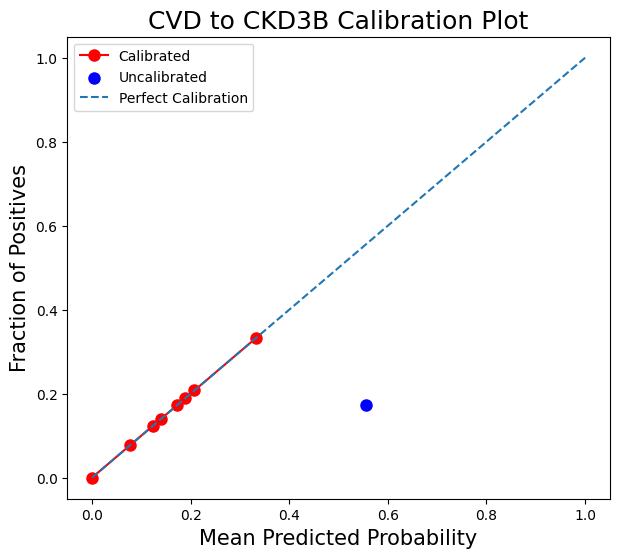

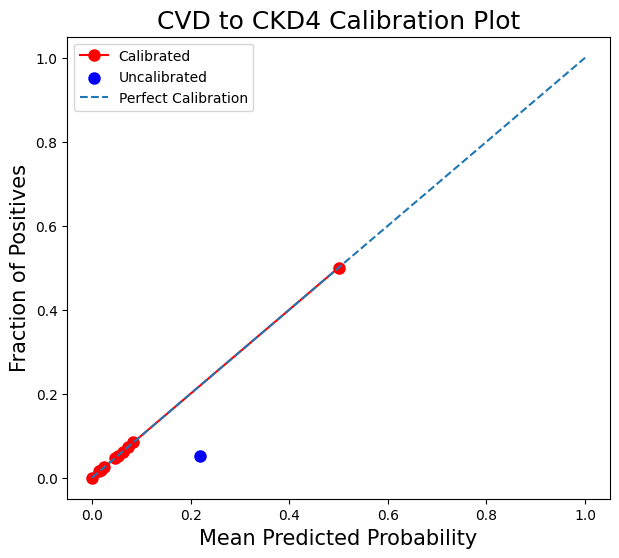

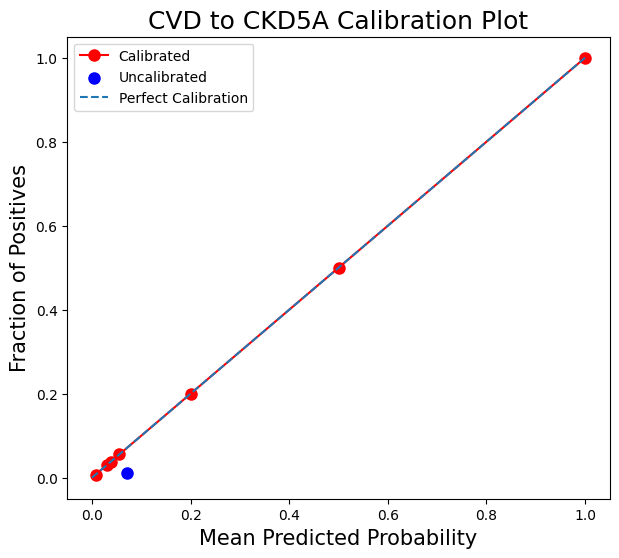

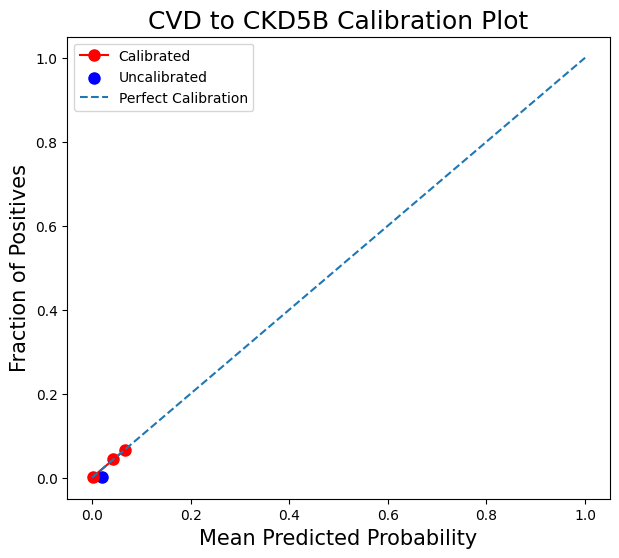

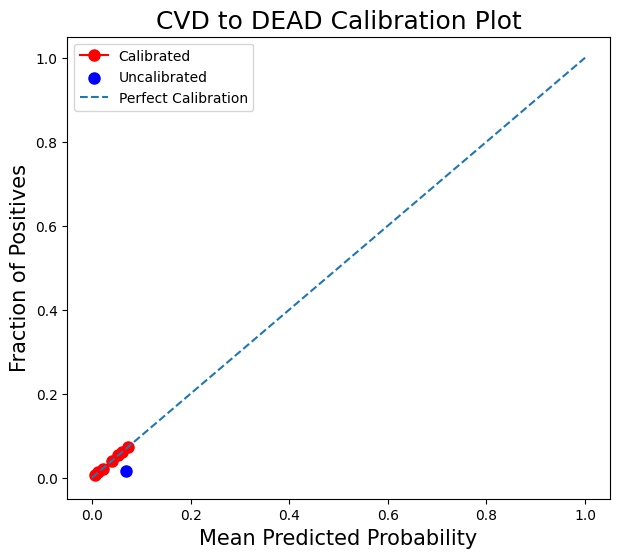

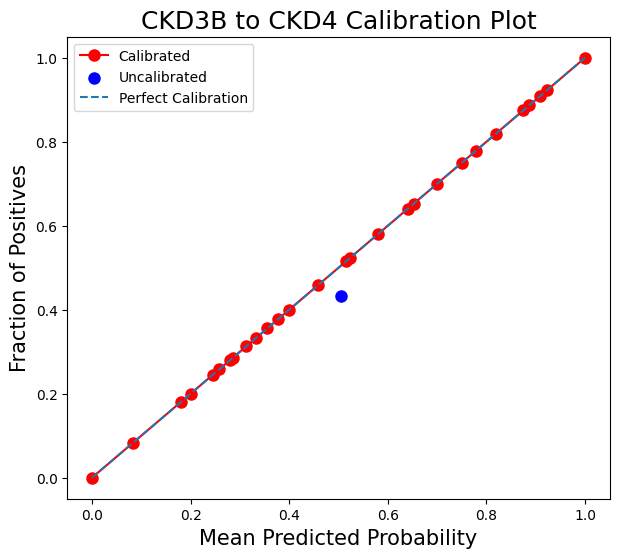

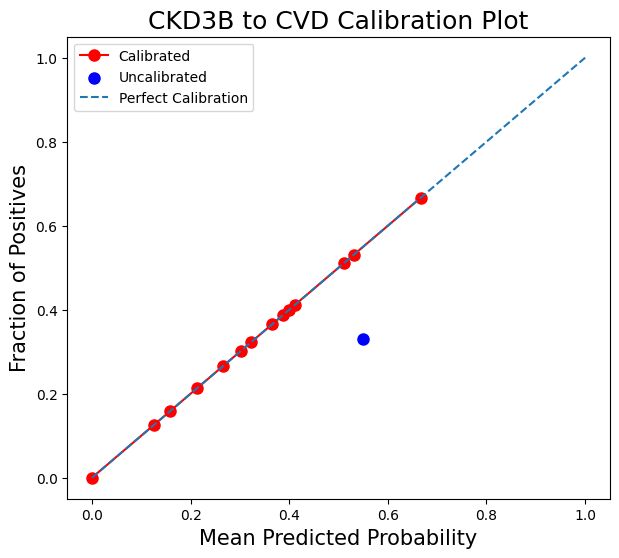

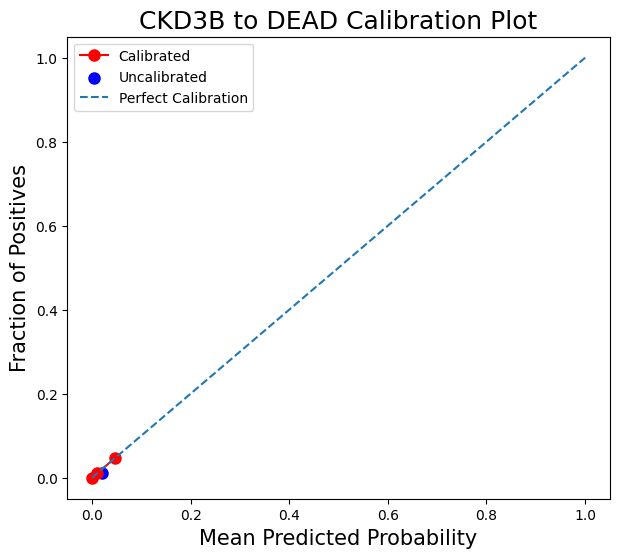

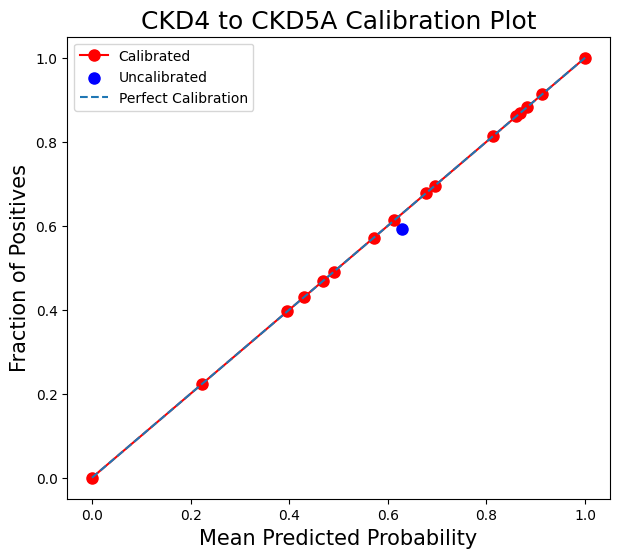

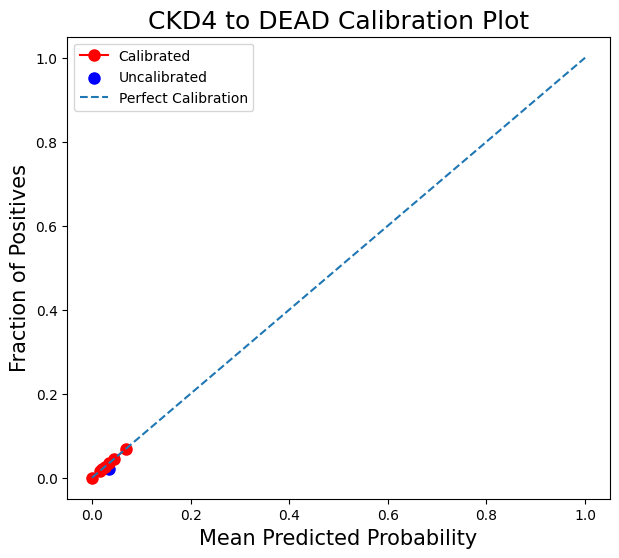

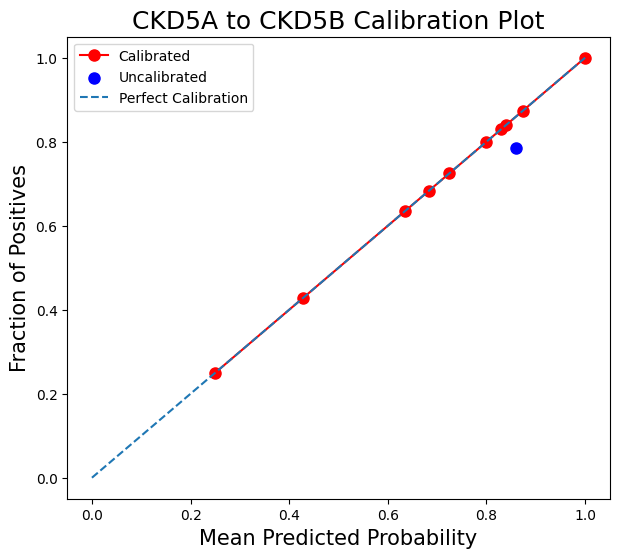

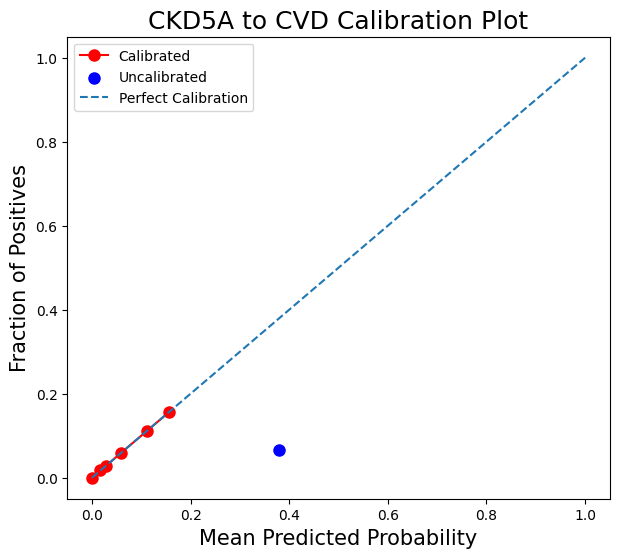

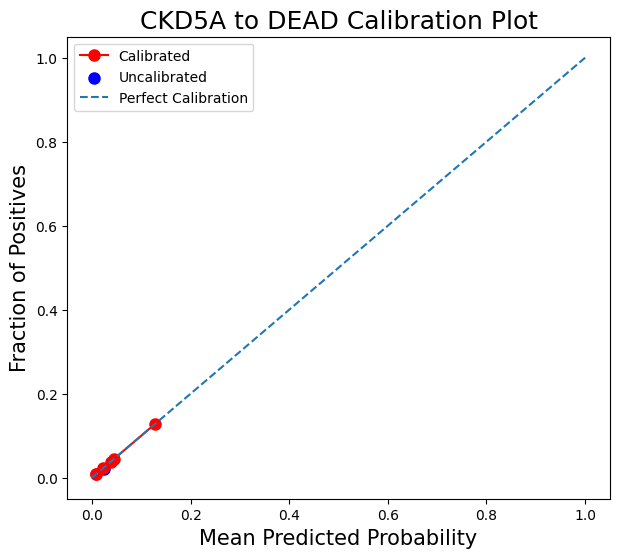

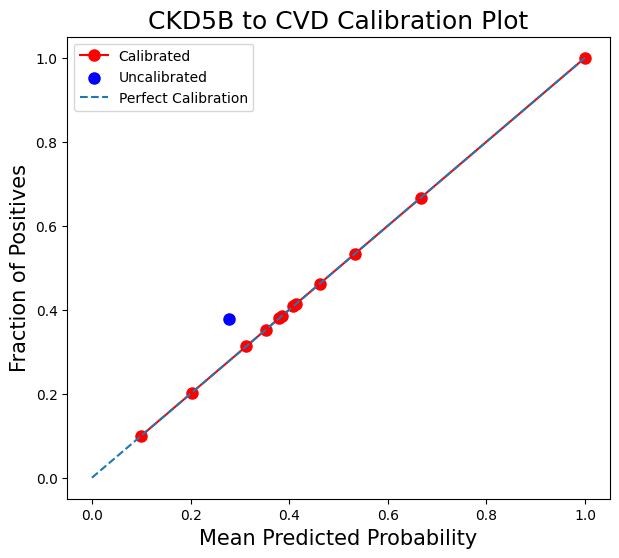

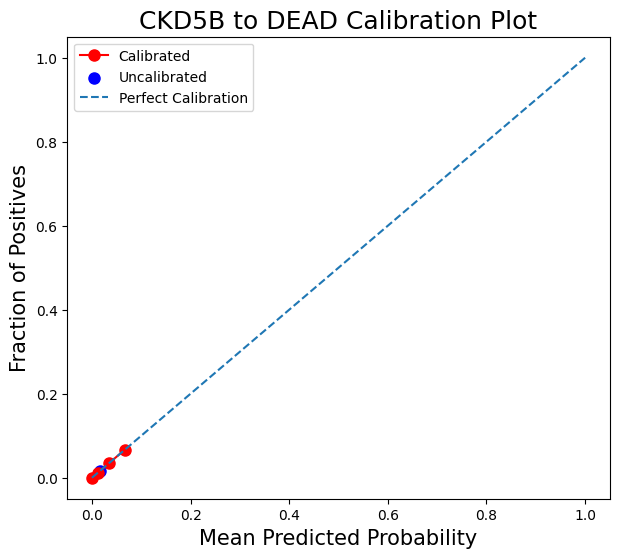

In [54]:
get_variance_inflation, get_interaction = True, False
get_importance = False
use_conformal  = True
use_platt = False
save_variance = True

folder_name, model_name = 'significance_vif_isotonic_conformal_ibs', 'survivalsvm'

main_survival_svm(folder_name, model_name, get_variance_inflation, get_interaction, get_importance, use_conformal, use_platt, save_variance)